<a href="https://colab.research.google.com/github/amohazab/modeling-mempool-congestion-using-agent-based-simulation/blob/main/Congestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Motivation:**

The main motivation behind this project is to analyse the problem of congection in the Bitcoin Payemtn System. We will use the agent-based simulation to model the environment and the agents:
Agent-based simulation has plenty of advantages such as:
- It is a useful tool especially when we are dealing with a heterogeneous environment, where we have different sets of agents with different characteristics and types.  
- Though it is obviously not the only tool to work with in dynamic environments, It makes the complicated dynamic problems more understandable and easier to implement.
- It is very useful when we have adaptive agents and we want to follow the effect of different state variables (information sets) on the final outputs.
This is a preliminary work. I update the results when I finish the simulations.


**Model:**

We do not model the miners in the protocol, since the congestion comes from the demand side of the market. Though it is definitely a valid question to ask whether the miners can impose congestion on the users. To answer this question you might want to read our [research paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3974688). 
But as I said, we do not care about the incentives of the miners and we just try to create a simple framework to model congestion and augment it little by little.
The simple initial model is as follows:

At each step of the game:
- We draw a number of newcomers from a Poissin distribution. They have a marginal valuations coming from a Uniform distribution. 
- The new bidders are added to the Mempool.
- All the active users observe only the previous market clearing price (the last accepted price in the previous round). Note that the "active" users are the new ones plus the people who have not yet sent their transactions
- For each user i:

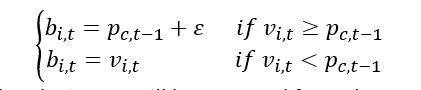

where b_i,t is then proposed amount by user to send his/her transaction, which we call bid from now on. p_c,t is the market clearing price i period t. v_i,t is the marginal valuation of the bidder from sending the transaction, and finally epsilon is an error. Note that epsilon is very important parameter here since we would not get expected results without it. We also assume that there is a discount factor for the users. In the case of not sending you transaction in this period, your valuation would decreases a little bit. To be more clear:


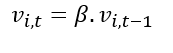

The main parameters of the model are as follows:

- Input rate (lambda): the parameter of the Poisson distribution
- Block size (BS): Which is constant thoughout the simulation.
- Error in bidding the previous market clearing price (epsilon)
- cost of losing (discount rate)
- Distribution of the marginal valuations (Uniform for now)

Now we get to the code.






In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# define bidder
class bidder():
    def __init__(self , u_id , m_v , c):
        self.u_id = u_id
        self.m_v = m_v
        self.cost = c
        self.active = True
        self.error = 0.05
    def step(self , prev_pc):
        bid = self.bid(prev_pc)
        return bid
        
    def bid(self , prev_pc):
        if prev_pc < self.m_v:
            bid = prev_pc + random.uniform(0 , self.error*(self.m_v - prev_pc))
        else:
            bid = self.m_v
        return bid

In [3]:
class BPS_model():
    def __init__(self , input_rate , block_size):
        self.input_rate = input_rate
        self.block_size = block_size
        self.p_c=0
        self.num_bidders = 0 #self.incoming(self.input_rate , self.duration)
        self.num_active_bidders = 0
        self.bidders={}
        # define cost
        self.cost = 0.1
        self.num_entrants = 0
        self.ave_pc = 0
        self.use_ave = False
        
    def step(self):
        # bidders come to the market
        n , m_v = self.incoming(self.input_rate)
        self.num_entrants = n
        for i in range(n):
            self.bidders[self.num_bidders + i] = bidder(self.num_bidders + i, m_v[i] , self.cost)
        
        #update index value
        self.num_bidders += n
    
        # ACTIVE bidders bid
        BIDS={}
        self.num_active_bidders=0
        
        for i in range(0,self.num_bidders):
            if self.bidders[i].active:
                self.num_active_bidders += 1
                if self.use_ave:
                    BIDS[self.bidders[i].u_id] = self.bidders[i].step(self.ave_pc)
                else:
                    BIDS[self.bidders[i].u_id] = self.bidders[i].step(self.p_c)
        
        
        # seller clears the market
        bid_list=list(BIDS.values())
        # likely for the first period 
        if self.num_active_bidders <= self.block_size:
            self.p_c=0
        else:
            self.p_c = bid_list[self.num_active_bidders-self.block_size]
        
        # determine NOT active bidders: accepted tx, zero m_v , negative m_v AND eliminate them from the schedule
        for j in BIDS:
            if BIDS[j] >= self.p_c or self.bidders[j].m_v <= 0:
                self.bidders[j].active = False
            else:
                self.bidders[j].m_v = (1-self.cost)*self.bidders[j].m_v
        
    
    def incoming(self , input_rate):
        input_list = np.random.poisson(input_rate , 1)
        N = input_list[0]
        #m_v = np.random.exponential(1 , N)
        m_v = np.random.uniform(0,10,N)
        return N , m_v
    
    def set_rate(self , alpha):
        self.input_rate = alpha
    
    def set_ave_pc(self , k):
        self.ave_pc = k
        
        

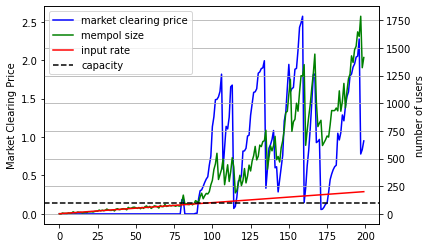

In [4]:
# create a sample for the market
game = BPS_model(1,100)
PC=[]
n_bidders=[]
n_active_bidders=[]
input_rate=[]
alpha = 1
ave_period = 1
num_entrant = []
for i in range(200):
    '''
    if i<150 or i>=300:
        alpha +=1
    else:
        alpha -=1
    '''
    alpha += 1
    game.set_rate(alpha)
    
    if i >= ave_period:
        game.use_ave = True
        average_price = np.mean(PC[len(PC)-ave_period:])
        game.set_ave_pc(average_price)
        game.step()
    else:
        game.step()
    PC.append(game.p_c)
    n_bidders.append(game.num_bidders)
    n_active_bidders.append(game.num_active_bidders)
    input_rate.append(game.input_rate)
    num_entrant.append(game.num_entrants)
x = [i for i in range(0,200)]

ax1 = plt.subplot()
#l1, = ax1.plot(x , num_entrant , color="blue")
l1, = ax1.plot(x , PC , color="blue")
ax2 = ax1.twinx()
l2, = ax2.plot(x , n_active_bidders , color='green')
l3, = ax2.plot(x , input_rate , color='red')

l4 = ax2.axhline(y= 100, color='k', linestyle='--')

plt.legend([l1, l2 , l3 , l4], ["market clearing price", "mempol size" , "input rate" , "capacity"])
ax2.set_ylabel("number of users")
ax1.set_ylabel("Market Clearing Price")
ax2.set_xlabel("number of steps")
plt.grid()
plt.show()
